# 05: DP-SGD Synthetic Data Generation

This notebook trains a differentially private variational autoencoder (DP-VAE) on DCA telemetry data and generates synthetic reporting tables for benchmark evaluation.

The approach extends the Q1 DP-VAE (`dsc-180a-q1/scripts/dp-vae.py`) to real multi-table DCA data. The key design decision: we synthesize at the guid level using a single wide training table, not per-table independently. This preserves cross-table correlations that the benchmark queries measure through JOINs.

## Outline

1. Build the guid-level wide training table from the 19 reporting tables
2. Preprocess: identify categorical vs numeric columns, encode, scale
3. Train DP-VAE with Opacus
4. Generate synthetic wide table
5. Decompose back into reporting table schemas
6. Run benchmark queries on synthetic tables, compare with ground truth

In [1]:
from pathlib import Path

import duckdb
import pandas as pd
from IPython.display import display, Markdown

REPORTING = Path("../data/reporting")
con = duckdb.connect()

---
## Step 1: Build the guid-level wide training table

Each row = one guid. Each column = either a sysinfo attribute or a pre-aggregated metric from a reporting table. All reporting tables are LEFT JOINed onto sysinfo so every guid in the anchor table gets a row, with NULLs for tables where that guid has no data.

We start by examining what each benchmark query actually computes from each table, so we know which aggregations to include.

### 1a. Sysinfo columns used by queries

The sysinfo table is the anchor. Queries reference these columns:
- `chassistype` (chassis join query, display queries)
- `countryname_normalized` (geographic queries)
- `os` (Xeon query)
- `cpuname` (Xeon query, to detect 'Xeon')
- `cpucode` (Xeon query)
- `ram` (server exploration, memory histogram)
- `persona` (persona pivot query)
- `modelvendor_normalized` (server exploration)
- `model_normalized` (server exploration)
- `#ofcores` (server exploration)

We keep all of these as categorical columns in the wide table.

In [2]:
sysinfo_cols = con.execute(f"""
    SELECT column_name 
    FROM (DESCRIBE SELECT * FROM read_parquet('{REPORTING}/system_sysinfo_unique_normalized.parquet'))
""").df()
display(Markdown(f"Sysinfo has {len(sysinfo_cols)} columns."))
display(sysinfo_cols)

Sysinfo has 32 columns.

,column_name
0,load_ts
1,guid
2,chassistype
3,chassistype_2in1_category
4,countryname
5,countryname_normalized
6,modelvendor
7,modelvendor_normalized
8,model
9,model_normalized


### 1b. Network consumption, aggregated to guid level

The two network queries compute:
- Total `nrs` per guid
- Total received bytes = `SUM(CASE WHEN input_desc = 'RECEIVED' THEN avg_bytes_sec * nrs * 5)`
- Total sent bytes = same pattern for 'SENT'

So the guid-level features are: `net_nrs`, `net_received_bytes`, `net_sent_bytes`.

In [3]:
net_agg = con.execute(f"""
    SELECT
        guid,
        SUM(nrs) AS net_nrs,
        SUM(CASE WHEN input_desc = 'OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::' 
            THEN CAST(avg_bytes_sec AS DOUBLE) * nrs * 5 ELSE 0 END) AS net_received_bytes,
        SUM(CASE WHEN input_desc = 'OS:NETWORK INTERFACE::BYTES SENT/SEC::' 
            THEN CAST(avg_bytes_sec AS DOUBLE) * nrs * 5 ELSE 0 END) AS net_sent_bytes
    FROM read_parquet('{REPORTING}/system_network_consumption.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"Network: {len(net_agg):,} guids, 3 features"))
display(net_agg.head())

Network: 37,224 guids, 3 features

,guid,net_nrs,net_received_bytes,net_sent_bytes
0,0069f374667a47c689b1409572fbb3b2,1308640.0,3.610989e+11,6.802389e+10
1,008b0d6b0149429393edbf2f6bb3e344,9649539.0,3.725572e+11,6.728549e+10
2,01028566e01c4b098d24d48db6533dd8,1390942.0,1.556277e+11,1.841153e+10
3,01139200682245e79bcbcd4bcd6876ee,4591025.0,9.785459e+11,1.897303e+10
4,01779fa602594808840d411f2247739d,11452424.0,3.125552e+11,2.487723e+10


### 1c. Memory utilization, aggregated to guid level

The RAM histogram query computes a weighted average: `SUM(nrs * avg_percentage_used) / SUM(nrs)` grouped by `sysinfo_ram`. The guid-level features are: `mem_nrs`, `mem_avg_pct_used`, `mem_sysinfo_ram`.

In [4]:
mem_agg = con.execute(f"""
    SELECT
        guid,
        SUM(nrs) AS mem_nrs,
        SUM(CAST(nrs AS DOUBLE) * avg_percentage_used) / SUM(nrs) AS mem_avg_pct_used,
        MAX(sysinfo_ram) AS mem_sysinfo_ram
    FROM read_parquet('{REPORTING}/system_memory_utilization.parquet')
    WHERE avg_percentage_used > 0
    GROUP BY guid
""").df()

display(Markdown(f"Memory: {len(mem_agg):,} guids, 3 features"))
display(mem_agg.head())

Memory: 69,497 guids, 3 features

,guid,mem_nrs,mem_avg_pct_used,mem_sysinfo_ram
0,1a14092574284b86ae9fce25f3cbef0c,851059.0,39.638257,32768
1,1a371794f2bc43b198364be679cc7dd8,361.0,33.193906,12288
2,1acf30e954ec45fcace0dde943118e5a,853537.0,43.279363,32768
3,1b2a4eade7e94c3090bdcf29106b059a,675525.0,64.479902,4096
4,1bddc7f1e6fc406e8396e176eeade457,5357713.0,62.053542,4096


### 1d. HW metric tables (power, C0, freq, temp), aggregated to guid level

The 5-way chassis query computes weighted averages: `SUM(nrs * avg_X) / SUM(nrs)` for each metric. Each becomes one guid-level feature.

In [5]:
hw_tables = {
    "psys_rap": ("system_psys_rap_watts", "avg_psys_rap_watts"),
    "pkg_c0": ("system_pkg_C0", "avg_pkg_c0"),
    "avg_freq": ("system_pkg_avg_freq_mhz", "avg_avg_freq_mhz"),
    "temp": ("system_pkg_temp_centigrade", "avg_temp_centigrade"),
    "pkg_power": ("system_hw_pkg_power", "mean"),
}

hw_aggs = {}
for name, (table, col) in hw_tables.items():
    df = con.execute(f"""
        SELECT
            guid,
            SUM(nrs) AS {name}_nrs,
            SUM(CAST(nrs AS DOUBLE) * {col}) / SUM(nrs) AS {name}_avg
        FROM read_parquet('{REPORTING}/{table}.parquet')
        GROUP BY guid
    """).df()
    hw_aggs[name] = df
    display(Markdown(f"{name}: {len(df):,} guids"))

display(Markdown(f"5 HW metric tables aggregated, 2 features each (nrs + weighted avg)."))

psys_rap: 611 guids

pkg_c0: 8,943 guids

avg_freq: 613 guids

temp: 622 guids

pkg_power: 800 guids

5 HW metric tables aggregated, 2 features each (nrs + weighted avg).

### 1e. Battery DC events, aggregated to guid level

Battery queries compute `AVG(num_power_ons)` and `AVG(duration_mins)` across guids. The guid-level features: `batt_num_power_ons`, `batt_duration_mins` (summed across all dates for that guid).

In [6]:
batt_agg = con.execute(f"""
    SELECT
        guid,
        SUM(num_power_ons) AS batt_num_power_ons,
        SUM(duration_mins) AS batt_duration_mins
    FROM read_parquet('{REPORTING}/system_batt_dc_events.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"Battery: {len(batt_agg):,} guids, 2 features"))
display(batt_agg.head())

Battery: 19,780 guids, 2 features

,guid,batt_num_power_ons,batt_duration_mins
0,abb9fcaa010c4a31bf0087a4cbdc4d6e,39.0,2945.0
1,0f8b3229d5bd44318eee701297a85cc1,128.0,7893.0
2,421dff1ec78c41e49a9adf0242cd0012,172.0,6125.0
3,0d3ad9d8d7dc42d8849524ce9c1c9606,12.0,844.0
4,6161ec069726434d95e55c2be3e49d48,18.0,199.0


### 1f. Web browsing: browser durations expanded as columns

The browser queries need per-browser stats. We expand browsers into separate columns per guid: `web_chrome_duration`, `web_edge_duration`, `web_firefox_duration`, plus system counts.

In [7]:
web_agg = con.execute(f"""
    SELECT
        guid,
        SUM(CASE WHEN browser = 'chrome' THEN duration_ms ELSE 0 END) AS web_chrome_duration,
        SUM(CASE WHEN browser = 'edge' THEN duration_ms ELSE 0 END) AS web_edge_duration,
        SUM(CASE WHEN browser = 'firefox' THEN duration_ms ELSE 0 END) AS web_firefox_duration,
        SUM(duration_ms) AS web_total_duration,
        COUNT(*) AS web_num_instances
    FROM read_parquet('{REPORTING}/system_web_cat_usage.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"Web browsing: {len(web_agg):,} guids, 5 features"))
display(web_agg.head())

Web browsing: 64,276 guids, 5 features

,guid,web_chrome_duration,web_edge_duration,web_firefox_duration,web_total_duration,web_num_instances
0,0d65745e1d314bd9b5eeddeef6d9a42f,0.000000e+00,3924715.0,0.0,3.924715e+06,1
1,0d6ef7b494b54cd49c9b5a56fb27a032,6.788732e+08,0.0,19401703.0,6.982749e+08,302
2,0d8aada3108045d6a3dd9f70dd014421,6.513240e+06,2997.0,0.0,6.516237e+06,13
3,0da36c24e026483d8f60687f767ebcfa,1.844785e+07,0.0,0.0,1.844785e+07,7
4,0dc29c90e8ae46508e6e4fc0e33277fa,1.201798e+09,188234.0,0.0,1.201987e+09,1028


### 1g. Web category pivot: 28 category durations per guid

The persona query uses the pivot table with 28 category columns. We sum each category across all dates per guid.

In [8]:
pivot_cols = con.execute(f"""
    SELECT column_name 
    FROM (DESCRIBE SELECT * FROM read_parquet('{REPORTING}/system_web_cat_pivot_duration.parquet'))
    WHERE column_name NOT IN ('guid', 'dt')
""").df()["column_name"].tolist()

sum_exprs = ", ".join([f'SUM("{c}") AS "webcat_{c}"' for c in pivot_cols])

webcat_agg = con.execute(f"""
    SELECT guid, {sum_exprs}
    FROM read_parquet('{REPORTING}/system_web_cat_pivot_duration.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"Web categories: {len(webcat_agg):,} guids, {len(pivot_cols)} category features"))
display(webcat_agg.head())

Web categories: 64,276 guids, 28 category features

,guid,webcat_content_creation_photo_edit_creation,webcat_content_creation_video_audio_edit_creation,webcat_content_creation_web_design_development,webcat_education,webcat_entertainment_music_audio_streaming,webcat_entertainment_other,webcat_entertainment_video_streaming,webcat_finance,webcat_games_other,...,webcat_productivity_project_management,webcat_productivity_spreadsheets,webcat_productivity_word_processing,webcat_recreation_travel,webcat_reference,webcat_search,webcat_shopping,webcat_social_social_network,webcat_social_communication,webcat_social_communication_live
0,17ded633edca4188b3ac0ceb0f1b63c1,0.0,0.0,0.0,44489.0,0.0,0.0,259285134.0,0.0,0.0,...,0.0,0.0,4198445.0,0.0,3266731.0,104758136.0,0.0,5189250.0,27502.0,12032260.0
1,18792ff92fbd4a2dba005d6fec06d609,5067828.0,0.0,13669.0,15087059.0,971350.0,892235683.0,613066177.0,20914667.0,197671.0,...,76531.0,43072.0,18467.0,19336944.0,195392037.0,224911455.0,185814671.0,89282872.0,5126304.0,0.0
2,1882868523c84c6994ae83ed8fd95e0c,0.0,0.0,11925.0,120166265.0,0.0,810194.0,34966103.0,16380632.0,673600206.0,...,0.0,0.0,0.0,0.0,449192.0,87294777.0,33484818.0,64420.0,31228148.0,0.0
3,188cd048f04d4826a10bec29b58066d9,2940774.0,0.0,3800.0,3063.0,0.0,157701.0,139988983.0,0.0,9712567.0,...,0.0,0.0,0.0,2490231.0,4273947.0,1472489.0,1427990.0,3351805.0,12456083.0,499.0
4,19afca046cc64277a4232431a8838211,5545.0,0.0,997634.0,1426602.0,1923.0,30891.0,8332773.0,27303.0,39470.0,...,0.0,411877787.0,323908505.0,9960.0,5247342.0,727869576.0,5355295.0,925606.0,15770607.0,555321826.0


### 1h. On/off/sleep time, aggregated to guid level

The on/off/mods/sleep query computes averages per guid. We sum across all dates.

In [9]:
onoff_agg = con.execute(f"""
    SELECT
        guid,
        SUM(on_time) AS onoff_on_time,
        SUM(off_time) AS onoff_off_time,
        SUM(mods_time) AS onoff_mods_time,
        SUM(sleep_time) AS onoff_sleep_time
    FROM read_parquet('{REPORTING}/system_on_off_suspend_time_day.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"On/off/sleep: {len(onoff_agg):,} guids, 4 features"))
display(onoff_agg.head())

On/off/sleep: 36,958 guids, 4 features

,guid,onoff_on_time,onoff_off_time,onoff_mods_time,onoff_sleep_time
0,a91448a634b143ef98993b384f97b26f,2049869.0,225602.0,0.0,4192345.0
1,b22c63ef1d29472b86d4ba707d76a614,3001570.0,184.0,0.0,0.0
2,0028fb1fe0194248b87e2f6ae7db39c7,527965.0,15781.0,0.0,5452676.0
3,1e93555d7a6848009fc2581f3f8e0e58,360574.0,61.0,0.0,1461270.0
4,28a5214fad3f4cfabdc7b570e1f338fb,1027855.0,49.0,0.0,2051359.0


### 1i. Display devices, aggregated to guid level

The display queries need connection type, resolution, vendor, and durations. We aggregate: number of displays, total AC duration, total DC duration per guid.

In [10]:
display_agg = con.execute(f"""
    SELECT
        guid,
        COUNT(DISTINCT display_id) AS disp_num_displays,
        SUM(duration_ac) AS disp_total_duration_ac,
        SUM(duration_dc) AS disp_total_duration_dc
    FROM read_parquet('{REPORTING}/system_display_devices.parquet')
    GROUP BY guid
""").df()

display(Markdown(f"Display: {len(display_agg):,} guids, 3 features"))
display(display_agg.head())

Display: 209,239 guids, 3 features

,guid,disp_num_displays,disp_total_duration_ac,disp_total_duration_dc
0,017b5332ed1f4aeaa12fbe119930cabd,8,4917104.0,1058043.0
1,071280225862434f83c867e003c8a1ea,2,23953.0,0.0
2,02f22b4e67fe4bdea88bb85f78b7cbfb,9,88964.0,0.0
3,000ee9c2c79e41438bccaa646a2226c9,3,648319.0,1123931.0
4,02cb292a8833454f9c1bcc1d53b48474,3,167389.0,0.0


### 1j. Join everything into the wide table

LEFT JOIN all guid-level aggregations onto sysinfo. Guids without data in a particular table get NULLs, which we fill with 0 for numeric columns.

In [11]:
sysinfo = con.execute(f"""
    SELECT guid, chassistype, countryname_normalized, modelvendor_normalized, 
           ram, os, cpuname, cpucode, cpu_family, persona, processornumber
    FROM read_parquet('{REPORTING}/system_sysinfo_unique_normalized.parquet')
""").df()

display(Markdown(f"Sysinfo anchor: {len(sysinfo):,} guids"))

wide = sysinfo.copy()

join_tables = [
    (net_agg, "net"),
    (mem_agg, "mem"),
    (batt_agg, "batt"),
    (web_agg, "web"),
    (webcat_agg, "webcat"),
    (onoff_agg, "onoff"),
    (display_agg, "disp"),
]

for df, prefix in join_tables:
    wide = wide.merge(df, on="guid", how="left")

for name, df in hw_aggs.items():
    wide = wide.merge(df, on="guid", how="left")

numeric_cols = [c for c in wide.columns if c != "guid" and wide[c].dtype in ["float64", "int64", "float32", "int32"]]
wide[numeric_cols] = wide[numeric_cols].fillna(0)

cat_cols = [c for c in wide.columns if c != "guid" and c not in numeric_cols]
wide[cat_cols] = wide[cat_cols].fillna("Unknown")

display(Markdown(f"Wide table: {len(wide):,} rows x {len(wide.columns)} columns"))
display(Markdown(f"Categorical: {len(cat_cols)} columns. Numeric: {len(numeric_cols)} columns."))
display(wide.head())

Sysinfo anchor: 1,000,000 guids

Wide table: 1,000,000 rows x 69 columns

Categorical: 9 columns. Numeric: 59 columns.

,guid,chassistype,countryname_normalized,modelvendor_normalized,ram,os,cpuname,cpucode,cpu_family,persona,...,psys_rap_nrs,psys_rap_avg,pkg_c0_nrs,pkg_c0_avg,avg_freq_nrs,avg_freq_avg,temp_nrs,temp_avg,pkg_power_nrs,pkg_power_avg
0,000091c0adc149389235ed2c5f15a59e,Desktop,Australia,Unknown,8.0,Win10,6th Gen i5,i5-6260U,Core i5,Casual User,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000af8fab2d4669bad5917875158ab9,Desktop,India,Gigabyte,8.0,Win10,10th Gen i5,i5-10400,Core i5,Casual User,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000cc165aa744638ec3ba6d7f1ab538,Desktop,"Korea, Republic of",Asus,16.0,Win10,10th Gen i5,i5-10400F,Core i5,Casual User,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0002b2fbaad04685b34c3fa59033493a,Notebook,Italy,HP,6.0,Win10,1st Gen i7,i7-720QM,Core i7,Unknown,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0002deb808fe4d6281c1159ebce45fad,Notebook,Brazil,Dell,4.0,Win10,Pentium/Celeron-Penryn,T6600,Pentium/Celeron,Unknown,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
wide.to_parquet("../data/reporting/wide_training_table.parquet", index=False)
display(Markdown(f"Saved wide training table: {len(wide):,} rows x {len(wide.columns)} columns"))

Saved wide training table: 1,000,000 rows x 69 columns

---
## Step 2: Preprocessing

Split columns into categorical (one-hot encode) and numeric (standard scale). This mirrors the Q1 DP-VAE preprocessing but with additional steps for the DCA data:

1. Clip numeric outliers (e.g., RAM reported in MB instead of GB)
2. Log-transform skewed numeric features (most have extreme right skew with many zeros)
3. One-hot encode categorical columns
4. StandardScale all numeric columns
5. Combine into a single feature matrix

In [13]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

wide = pd.read_parquet("../data/reporting/wide_training_table.parquet")

cat_cols = ["chassistype", "countryname_normalized", "modelvendor_normalized",
            "os", "cpuname", "cpucode", "cpu_family", "persona", "processornumber"]
numeric_cols = [c for c in wide.columns if c != "guid" and c not in cat_cols]

display(Markdown(f"Starting shape: {wide.shape[0]:,} rows, {len(cat_cols)} categorical, {len(numeric_cols)} numeric"))

cat_info = []
for c in cat_cols:
    cat_info.append({"column": c, "unique": wide[c].nunique(), "top": wide[c].value_counts().index[0]})
display(pd.DataFrame(cat_info))

Starting shape: 1,000,000 rows, 9 categorical, 59 numeric

,column,unique,top
0,chassistype,7,Notebook
1,countryname_normalized,51,United States of America
2,modelvendor_normalized,48,HP
3,os,7,Win10
4,cpuname,116,8th Gen i5
5,cpucode,1798,Unknown
6,cpu_family,10,Core i5
7,persona,11,Web User
8,processornumber,13,14 nm


In [14]:
TOP_K = 50

for c in cat_cols:
    if wide[c].nunique() > TOP_K:
        top_values = wide[c].value_counts().head(TOP_K).index
        wide[c] = wide[c].where(wide[c].isin(top_values), "Other")

display(Markdown("After top-k binning:"))
cat_info2 = []
for c in cat_cols:
    cat_info2.append({"column": c, "unique": wide[c].nunique()})
display(pd.DataFrame(cat_info2))
display(Markdown(f"Total one-hot dimensions: {sum(d['unique'] for d in cat_info2)}"))

After top-k binning:

,column,unique
0,chassistype,7
1,countryname_normalized,50
2,modelvendor_normalized,48
3,os,7
4,cpuname,51
5,cpucode,51
6,cpu_family,10
7,persona,11
8,processornumber,13


Total one-hot dimensions: 248

### 2b. Clip outliers and log-transform numeric features

Most numeric columns are heavily right-skewed with many zeros. Raw StandardScaling would compress all the nonzero values into a tiny range. Instead:

1. Clip extreme outliers at the 99.9th percentile
2. Apply log1p transform: log(1 + x). This compresses the range while handling zeros gracefully (log(1+0) = 0).
3. Then StandardScale the log-transformed values.

In [15]:
clip_bounds = {}
for c in numeric_cols:
    p999 = wide[c].quantile(0.999)
    if p999 > 0:
        clip_bounds[c] = p999
        wide[c] = wide[c].clip(upper=p999)

wide[numeric_cols] = np.log1p(wide[numeric_cols].astype(np.float64))

display(Markdown(f"Clipped {len(clip_bounds)} columns at 99.9th percentile, then applied log1p."))
display(wide[numeric_cols].describe().T[["mean", "std", "min", "max"]])

Clipped 50 columns at 99.9th percentile, then applied log1p.

,mean,std,min,max
ram,2.311970,0.572357,0.0,4.859812
net_nrs,0.495537,2.547110,0.0,16.128645
net_received_bytes,0.938154,4.793202,0.0,28.732138
net_sent_bytes,0.850151,4.362027,0.0,27.433451
mem_nrs,0.865936,3.222329,0.0,16.157793
mem_avg_pct_used,0.272314,1.000971,0.0,4.439060
mem_sysinfo_ram,0.639114,2.344259,0.0,10.397238
batt_num_power_ons,0.061855,0.470308,0.0,5.135798
batt_duration_mins,0.126253,0.938513,0.0,9.507255
web_chrome_duration,0.964550,4.142796,0.0,22.762345


### 2c. Encode and scale

One-hot encode categoricals, StandardScale numerics. Combine into a single feature matrix. This is the input to the DP-VAE.

In [16]:
transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

feature_matrix = transformer.fit_transform(wide[cat_cols + numeric_cols])

cat_encoder = transformer.named_transformers_["cat"]
num_scaler = transformer.named_transformers_["num"]

cat_sizes = [len(cats) for cats in cat_encoder.categories_]
cat_total = sum(cat_sizes)
num_total = len(numeric_cols)

display(Markdown(
    f"Feature matrix: {feature_matrix.shape[0]:,} x {feature_matrix.shape[1]}\n\n"
    f"Categorical one-hot: {cat_total} dims ({len(cat_sizes)} columns)\n\n"
    f"Numeric scaled: {num_total} dims\n\n"
    f"Categorical sizes: {list(zip(cat_cols, cat_sizes))}"
))

Feature matrix: 1,000,000 x 307

Categorical one-hot: 248 dims (9 columns)

Numeric scaled: 59 dims

Categorical sizes: [('chassistype', 7), ('countryname_normalized', 50), ('modelvendor_normalized', 48), ('os', 7), ('cpuname', 51), ('cpucode', 51), ('cpu_family', 10), ('persona', 11), ('processornumber', 13)]

### 2d. Prepare PyTorch tensors

Build the dataset and extract targets for the VAE loss function:
- Categorical targets: argmax indices per categorical column (for cross-entropy loss)
- Numeric targets: the scaled numeric values (for MSE loss)

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

cat_target_list = []
offset = 0
for size in cat_sizes:
    block = feature_matrix[:, offset:offset + size]
    cat_target_list.append(block.argmax(axis=1))
    offset += size

cat_targets = np.stack(cat_target_list, axis=1).astype(np.int64)
num_targets = feature_matrix[:, cat_total:].astype(np.float32)

features_tensor = torch.tensor(feature_matrix, dtype=torch.float32)
cat_targets_tensor = torch.tensor(cat_targets, dtype=torch.long)
num_targets_tensor = torch.tensor(num_targets, dtype=torch.float32)


class WideTableDataset(Dataset):
    def __init__(self, features, cat_targets, num_targets):
        self.features = features
        self.cat_targets = cat_targets
        self.num_targets = num_targets

    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, idx):
        return self.features[idx], self.cat_targets[idx], self.num_targets[idx]


dataset = WideTableDataset(features_tensor, cat_targets_tensor, num_targets_tensor)

display(Markdown(
    f"Dataset ready: {len(dataset):,} samples\n\n"
    f"Feature dim: {features_tensor.shape[1]}\n\n"
    f"Categorical targets: {cat_targets_tensor.shape[1]} columns\n\n"
    f"Numeric targets: {num_targets_tensor.shape[1]} columns"
))

Dataset ready: 1,000,000 samples

Feature dim: 307

Categorical targets: 9 columns

Numeric targets: 59 columns

---
## Step 3: DP-VAE Model

Same architecture as Q1 (`dsc-180a-q1/scripts/dp-vae.py`), scaled up for the wider input. The encoder maps the full feature vector to a latent space. The decoder produces logits for each categorical column (cross-entropy loss) and continuous predictions for each numeric column (MSE loss). KL divergence regularizes the latent space toward N(0,I).

Hyperparameters are adapted from Q1, with hidden size increased to accommodate the larger input.

In [18]:
BATCH_SIZE = 4096
LATENT_DIM = 64
HIDDEN_SIZE = 512
EPOCHS = 20
MAX_GRAD_NORM = 1.0
TARGET_EPSILON = 4.0
DELTA = 1e-5
LR = 1e-3


class DCAWidetableVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cat_sizes, num_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
        )
        self.mean_layer = nn.Linear(HIDDEN_SIZE, latent_dim)
        self.logvar_layer = nn.Linear(HIDDEN_SIZE, latent_dim)

        self.cat_decoders = nn.ModuleList(
            [nn.Linear(latent_dim, size) for size in cat_sizes]
        )
        self.num_decoder = nn.Linear(latent_dim, num_dim)

    def encode(self, x):
        h = self.encoder(x)
        return self.mean_layer(h), self.logvar_layer(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        cat_logits = [dec(z) for dec in self.cat_decoders]
        num_out = self.num_decoder(z)
        return cat_logits, num_out

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        cat_logits, num_out = self.decode(z)
        return cat_logits, num_out, mean, logvar


input_dim = features_tensor.shape[1]

display(Markdown(
    f"Model config:\n\n"
    f"- Input dim: {input_dim}\n"
    f"- Hidden size: {HIDDEN_SIZE}\n"
    f"- Latent dim: {LATENT_DIM}\n"
    f"- Categorical decoders: {len(cat_sizes)} (sizes: {cat_sizes})\n"
    f"- Numeric decoder output: {num_total}\n"
    f"- Batch size: {BATCH_SIZE}\n"
    f"- Target epsilon: {TARGET_EPSILON}, delta: {DELTA}\n"
    f"- Noise multiplier: auto-calibrated, max grad norm: {MAX_GRAD_NORM}"
))

Model config:

- Input dim: 307
- Hidden size: 512
- Latent dim: 64
- Categorical decoders: 9 (sizes: [7, 50, 48, 7, 51, 51, 10, 11, 13])
- Numeric decoder output: 59
- Batch size: 4096
- Target epsilon: 4.0, delta: 1e-05
- Noise multiplier: auto-calibrated, max grad norm: 1.0

---
## Step 4: Train with DP-SGD (Opacus)

Opacus wraps the model, optimizer, and dataloader to inject per-sample gradient clipping and calibrated Gaussian noise at each step. The privacy accountant tracks cumulative epsilon spend. Training stops when the target epsilon is reached or all epochs complete.

In [19]:
import time
from opacus import PrivacyEngine

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

display(Markdown(f"Device: `{device}`"))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

model = DCAWidetableVAE(
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    cat_sizes=cat_sizes,
    num_dim=num_total,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
cat_loss_fn = nn.CrossEntropyLoss()
num_loss_fn = nn.MSELoss()

privacy_engine = PrivacyEngine()
model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=dataloader,
    epochs=EPOCHS,
    target_epsilon=TARGET_EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

total_params = sum(p.numel() for p in model.parameters())
actual_sigma = optimizer.noise_multiplier
display(Markdown(
    f"Model parameters: {total_params:,}. Privacy engine attached.\n\n"
    f"Auto-calibrated noise multiplier: {actual_sigma:.4f} (to reach ε={TARGET_EPSILON} over {EPOCHS} epochs)"
))

Device: `cpu`

/Users/enscribe/Repositories/School/dsc180-q2/.venv/lib/python3.12/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Users/enscribe/Repositories/School/dsc180-q2/.venv/lib/python3.12/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
02/11/2026 04:17:19:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


Model parameters: 505,971. Privacy engine attached.

Auto-calibrated noise multiplier: 0.6873 (to reach ε=4.0 over 20 epochs)

In [20]:
def kl_divergence(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()


epsilon_history = []
loss_history = []
t_start = time.time()

for epoch in range(1, EPOCHS + 1):
    t_epoch = time.time()
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch_features, batch_cat_targets, batch_num_targets in dataloader:
        batch_features = batch_features.to(device)
        batch_cat_targets = batch_cat_targets.to(device)
        batch_num_targets = batch_num_targets.to(device)

        optimizer.zero_grad()
        cat_logits, num_pred, mean, logvar = model(batch_features)

        cat_loss_val = sum(
            cat_loss_fn(logits, batch_cat_targets[:, i])
            for i, logits in enumerate(cat_logits)
        )
        num_loss_val = num_loss_fn(num_pred, batch_num_targets)
        kl_val = kl_divergence(mean, logvar)

        loss = cat_loss_val + num_loss_val + kl_val
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_features.size(0)
        n_batches += 1

    epoch_loss = running_loss / len(dataset)
    epoch_sec = time.time() - t_epoch
    remaining_sec = epoch_sec * (EPOCHS - epoch)

    try:
        epsilon = privacy_engine.accountant.get_epsilon(delta=DELTA)
    except Exception:
        epsilon = float("nan")

    epsilon_history.append(epsilon)
    loss_history.append(epoch_loss)

    display(Markdown(
        f"Epoch {epoch:02d}: loss={epoch_loss:.4f}, ε={epsilon:.3f} "
        f"({epoch_sec:.0f}s/epoch, ~{remaining_sec / 60:.0f}min remaining)"
    ))

    if np.isfinite(TARGET_EPSILON) and np.isfinite(epsilon) and epsilon >= TARGET_EPSILON:
        display(Markdown(f"Target ε={TARGET_EPSILON} reached. Stopping."))
        break

total_min = (time.time() - t_start) / 60
display(Markdown(f"Training complete in {total_min:.1f} minutes. Final ε={epsilon_history[-1]:.3f} at δ={DELTA}."))

/var/folders/_f/171dt4kn19sf0yq1gqhrb_lh0000gn/T/ipykernel_7897/3312655164.py:31: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Epoch 01: loss=23.7622, ε=1.645 (1253s/epoch, ~397min remaining)

Epoch 02: loss=20.9521, ε=1.919 (1084s/epoch, ~325min remaining)

Epoch 03: loss=20.2980, ε=2.117 (978s/epoch, ~277min remaining)

Epoch 04: loss=19.9154, ε=2.283 (1092s/epoch, ~291min remaining)

Epoch 05: loss=19.6992, ε=2.430 (1055s/epoch, ~264min remaining)

Epoch 06: loss=19.4422, ε=2.566 (1075s/epoch, ~251min remaining)

Epoch 07: loss=19.2577, ε=2.693 (1090s/epoch, ~236min remaining)

Epoch 08: loss=19.0777, ε=2.814 (1092s/epoch, ~218min remaining)

Epoch 09: loss=18.8628, ε=2.929 (1077s/epoch, ~197min remaining)

Epoch 10: loss=18.6364, ε=3.040 (1073s/epoch, ~179min remaining)

Epoch 11: loss=18.4671, ε=3.147 (1080s/epoch, ~162min remaining)

Epoch 12: loss=18.3102, ε=3.251 (1085s/epoch, ~145min remaining)

Epoch 13: loss=18.1113, ε=3.351 (1070s/epoch, ~125min remaining)

Epoch 14: loss=17.9882, ε=3.450 (1085s/epoch, ~108min remaining)

Epoch 15: loss=17.7876, ε=3.546 (1082s/epoch, ~90min remaining)

Epoch 16: loss=17.7178, ε=3.639 (1101s/epoch, ~73min remaining)

Epoch 17: loss=17.6200, ε=3.731 (1058s/epoch, ~53min remaining)

Epoch 18: loss=17.4995, ε=3.821 (1039s/epoch, ~35min remaining)

Epoch 19: loss=17.4214, ε=3.909 (1053s/epoch, ~18min remaining)

Epoch 20: loss=17.3097, ε=3.996 (1057s/epoch, ~0min remaining)

Training complete in 359.7 minutes. Final ε=3.996 at δ=1e-05.

### 4a. Save model checkpoint

Save the trained model, preprocessing artifacts, and training history. This avoids re-running the 6-hour training loop if the kernel restarts or outputs are cleared.

To reload later:
```python
checkpoint = torch.load("../data/models/dp_vae_checkpoint.pt")
model = DCAWidetableVAE(**checkpoint["model_args"])
model.load_state_dict(checkpoint["model_state_dict"])
```

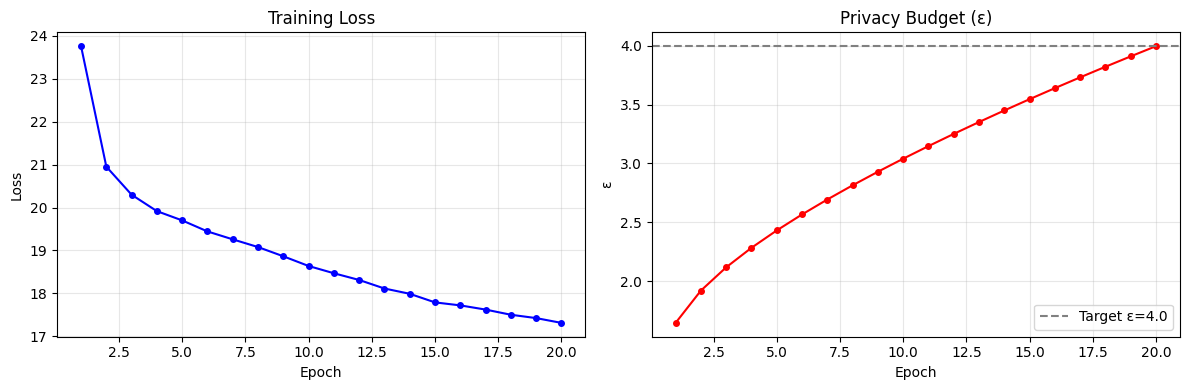

Saved model checkpoint to `data/models/dp_vae_checkpoint.pt`

Saved transformer to `data/models/transformer.pkl`

In [22]:
import pickle
import matplotlib.pyplot as plt

models_dir = Path("../data/models")
models_dir.mkdir(parents=True, exist_ok=True)

checkpoint = {
    "model_state_dict": model._module.state_dict(),
    "model_args": {
        "input_dim": input_dim,
        "latent_dim": LATENT_DIM,
        "cat_sizes": cat_sizes,
        "num_dim": num_total,
    },
    "cat_cols": cat_cols,
    "numeric_cols": numeric_cols,
    "clip_bounds": clip_bounds,
    "final_epsilon": epsilon_history[-1],
    "delta": DELTA,
    "loss_history": loss_history,
    "epsilon_history": epsilon_history,
}
torch.save(checkpoint, models_dir / "dp_vae_checkpoint.pt")

with open(models_dir / "transformer.pkl", "wb") as f:
    pickle.dump(transformer, f)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, len(loss_history) + 1), loss_history, "b-o", markersize=4)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, len(epsilon_history) + 1), epsilon_history, "r-o", markersize=4)
ax2.axhline(y=TARGET_EPSILON, color="gray", linestyle="--", label=f"Target ε={TARGET_EPSILON}")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("ε")
ax2.set_title("Privacy Budget (ε)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(models_dir / "training_curves.png"), dpi=150, bbox_inches="tight")
plt.show()

display(Markdown(
    f"Saved model checkpoint to `data/models/dp_vae_checkpoint.pt`\n\n"
    f"Saved transformer to `data/models/transformer.pkl`"
))

---
## Step 5: Generate synthetic wide table

Sample 1M latent vectors z ~ N(0, I) and decode through the trained DP-VAE. Inverse transform outputs back to the original data space:
- Categoricals: sample from softmax distributions, map indices back to labels
- Numerics: inverse StandardScale, then expm1 (inverse of log1p), clip negatives to 0

In [23]:
model.eval()
N_SYNTH = 1_000_000
GEN_BATCH = 50_000

synth_cat_all = []
synth_num_all = []

with torch.no_grad():
    for start in range(0, N_SYNTH, GEN_BATCH):
        batch_n = min(GEN_BATCH, N_SYNTH - start)
        z = torch.randn(batch_n, LATENT_DIM, device=device)
        cat_logits, num_out = model._module.decode(z)

        cat_indices = []
        for logits in cat_logits:
            probs = torch.softmax(logits, dim=1)
            samples = torch.multinomial(probs, 1).squeeze(1)
            cat_indices.append(samples.cpu().numpy())

        synth_cat_all.append(np.stack(cat_indices, axis=1))
        synth_num_all.append(num_out.cpu().numpy())

synth_cat_indices = np.concatenate(synth_cat_all, axis=0)
synth_num_scaled = np.concatenate(synth_num_all, axis=0)

synth_cat_labels = {}
for i, col in enumerate(cat_cols):
    synth_cat_labels[col] = cat_encoder.categories_[i][synth_cat_indices[:, i]]

synth_num_original = num_scaler.inverse_transform(synth_num_scaled)
synth_num_original = np.expm1(synth_num_original)
synth_num_original = np.clip(synth_num_original, 0, None)

synth_wide = pd.DataFrame(synth_cat_labels)
for j, col in enumerate(numeric_cols):
    synth_wide[col] = synth_num_original[:, j]

synth_wide.insert(0, "guid", [f"synth_{i:07d}" for i in range(N_SYNTH)])
synth_wide.to_parquet("../data/reporting/synth_wide_training_table.parquet", index=False)

display(Markdown(f"Generated {N_SYNTH:,} synthetic rows. Saved to `data/reporting/synth_wide_training_table.parquet`"))
display(synth_wide.head())
display(synth_wide[numeric_cols].describe().T[["mean", "std", "min", "max"]])

Generated 1,000,000 synthetic rows. Saved to `data/reporting/synth_wide_training_table.parquet`

,guid,chassistype,countryname_normalized,modelvendor_normalized,os,cpuname,cpucode,cpu_family,persona,processornumber,...,psys_rap_nrs,psys_rap_avg,pkg_c0_nrs,pkg_c0_avg,avg_freq_nrs,avg_freq_avg,temp_nrs,temp_avg,pkg_power_nrs,pkg_power_avg
0,synth_0000000,Notebook,Brazil,Intel,Win10,6th Gen i3,i3-5005U,Core i3,Web User,14 nm,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007091,0.0,0.000000,0.0
1,synth_0000001,Intel NUC/STK,Other,Intel,Win10,8th Gen i3,i3-7100U,Core i7,Win Store App User,14 nm,...,0.008338,0.006324,0.128575,0.025587,0.000341,0.000000,0.031548,0.0,0.000000,0.0
2,synth_0000002,Notebook,Brazil,Toshiba,Win10,4th Gen i3,i3-7100U,Core i3,Casual Gamer,22 nm,...,0.010535,0.001280,0.091813,0.000000,0.013890,0.000000,0.026333,0.0,0.000000,0.0
3,synth_0000003,Notebook,China,Intel,Win10,7th Gen i5,i5-8265U,Core i5,Gamer,14 nm,...,0.013335,0.000000,0.000000,0.000000,0.012374,0.032388,0.000000,0.0,0.006193,0.0
4,synth_0000004,Notebook,United States of America,Asus,Win10,3rd Gen i7,Other,Core2,Gamer,22 nm,...,0.031136,0.000808,0.000000,0.000000,0.018351,0.000000,0.021262,0.0,0.000000,0.0


,mean,std,min,max
ram,9.275042,2.626961,2.054969,3.240177e+01
net_nrs,0.203384,0.232486,0.000000,2.781834e+00
net_received_bytes,0.781058,0.986852,0.000000,2.221593e+01
net_sent_bytes,0.659648,0.764745,0.000000,1.358527e+01
mem_nrs,0.739666,0.620210,0.000000,8.429754e+00
mem_avg_pct_used,0.214020,0.118675,0.000000,1.020040e+00
mem_sysinfo_ram,0.497641,0.343901,0.000000,4.189088e+00
batt_num_power_ons,0.048912,0.053813,0.000000,4.047545e-01
batt_duration_mins,0.090082,0.107626,0.000000,1.106382e+00
web_chrome_duration,0.564057,0.658770,0.000000,1.387547e+01


---
## Step 6: Decompose into synthetic reporting tables

Reconstruct individual reporting tables from the synthetic wide table, mapping wide-table columns back to the original schemas the benchmark SQL expects.

Tables reconstructed (12): sysinfo, network consumption, memory utilization, 5 HW metric tables, battery events, web browsing, web category pivot, on/off/sleep time.

Tables not in the wide table (queries skipped for evaluation): userwait, frgnd_apps, display devices, blocker history, OS codename history, CPU metadata (generation column).

In [24]:
SYNTH_REPORTING = Path("../data/reporting/synthetic")
SYNTH_REPORTING.mkdir(parents=True, exist_ok=True)

sw = synth_wide

standard_ram_gb = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 128])

def snap_ram(val):
    return int(standard_ram_gb[np.argmin(np.abs(standard_ram_gb - val))])

sysinfo_synth = sw[["guid", "chassistype", "countryname_normalized", "modelvendor_normalized",
                     "ram", "os", "cpuname", "cpucode", "cpu_family", "persona", "processornumber"]].copy()
sysinfo_synth["ram"] = sysinfo_synth["ram"].apply(snap_ram)
sysinfo_synth.to_parquet(SYNTH_REPORTING / "system_sysinfo_unique_normalized.parquet", index=False)

net_mask = sw["net_nrs"] > 0
net_g = sw.loc[net_mask, ["guid", "net_nrs", "net_received_bytes", "net_sent_bytes"]].copy()
half_nrs = (net_g["net_nrs"] / 2).clip(lower=1)
received = pd.DataFrame({
    "guid": net_g["guid"].values,
    "input_desc": "OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::",
    "nrs": half_nrs.values,
    "avg_bytes_sec": (net_g["net_received_bytes"].values / (half_nrs.values * 5)),
})
sent = pd.DataFrame({
    "guid": net_g["guid"].values,
    "input_desc": "OS:NETWORK INTERFACE::BYTES SENT/SEC::",
    "nrs": half_nrs.values,
    "avg_bytes_sec": (net_g["net_sent_bytes"].values / (half_nrs.values * 5)),
})
net_synth = pd.concat([received, sent], ignore_index=True)
net_synth.to_parquet(SYNTH_REPORTING / "system_network_consumption.parquet", index=False)

mem_mask = sw["mem_nrs"] > 0
mem_ram_mb = sw.loc[mem_mask, "ram"].apply(snap_ram) * 1024
mem_synth = pd.DataFrame({
    "guid": sw.loc[mem_mask, "guid"].values,
    "nrs": sw.loc[mem_mask, "mem_nrs"].values,
    "avg_percentage_used": sw.loc[mem_mask, "mem_avg_pct_used"].values.clip(0, 100),
    "sysinfo_ram": mem_ram_mb.values,
})
mem_synth.to_parquet(SYNTH_REPORTING / "system_memory_utilization.parquet", index=False)

hw_map = {
    "system_psys_rap_watts": ("psys_rap_nrs", "psys_rap_avg", "avg_psys_rap_watts"),
    "system_pkg_C0": ("pkg_c0_nrs", "pkg_c0_avg", "avg_pkg_c0"),
    "system_pkg_avg_freq_mhz": ("avg_freq_nrs", "avg_freq_avg", "avg_avg_freq_mhz"),
    "system_pkg_temp_centigrade": ("temp_nrs", "temp_avg", "avg_temp_centigrade"),
    "system_hw_pkg_power": ("pkg_power_nrs", "pkg_power_avg", "mean"),
}
hw_counts = {}
for table_name, (nrs_col, avg_col, target_col) in hw_map.items():
    mask = sw[nrs_col] > 0
    df = pd.DataFrame({
        "guid": sw.loc[mask, "guid"].values,
        "nrs": sw.loc[mask, nrs_col].values,
        target_col: sw.loc[mask, avg_col].values,
    })
    df.to_parquet(SYNTH_REPORTING / f"{table_name}.parquet", index=False)
    hw_counts[table_name] = len(df)

batt_mask = sw["batt_num_power_ons"] > 0
batt_synth = pd.DataFrame({
    "guid": sw.loc[batt_mask, "guid"].values,
    "num_power_ons": sw.loc[batt_mask, "batt_num_power_ons"].values,
    "duration_mins": sw.loc[batt_mask, "batt_duration_mins"].values,
})
batt_synth.to_parquet(SYNTH_REPORTING / "system_batt_dc_events.parquet", index=False)

browsers = [("chrome", "web_chrome_duration"), ("edge", "web_edge_duration"), ("firefox", "web_firefox_duration")]
web_rows = []
for browser_name, dur_col in browsers:
    mask = sw[dur_col] > 0
    df = pd.DataFrame({
        "guid": sw.loc[mask, "guid"].values,
        "browser": browser_name,
        "duration_ms": sw.loc[mask, dur_col].values,
    })
    web_rows.append(df)
web_synth = pd.concat(web_rows, ignore_index=True)
web_synth.to_parquet(SYNTH_REPORTING / "system_web_cat_usage.parquet", index=False)

webcat_cols_map = {c: c.replace("webcat_", "") for c in sw.columns if c.startswith("webcat_")}
pivot_synth = sw[["guid"]].copy()
for wide_col, pivot_col in webcat_cols_map.items():
    pivot_synth[pivot_col] = sw[wide_col].values
pivot_synth.to_parquet(SYNTH_REPORTING / "system_web_cat_pivot_duration.parquet", index=False)

onoff_synth = pd.DataFrame({
    "guid": sw["guid"].values,
    "on_time": sw["onoff_on_time"].values,
    "off_time": sw["onoff_off_time"].values,
    "mods_time": sw["onoff_mods_time"].values,
    "sleep_time": sw["onoff_sleep_time"].values,
})
onoff_synth.to_parquet(SYNTH_REPORTING / "system_on_off_suspend_time_day.parquet", index=False)

display(Markdown(
    f"Saved 12 synthetic reporting tables to `data/reporting/synthetic/`\n\n"
    f"| Table | Rows |\n|---|---|\n"
    f"| sysinfo | {len(sysinfo_synth):,} |\n"
    f"| network_consumption | {len(net_synth):,} |\n"
    f"| memory_utilization | {len(mem_synth):,} |\n"
    f"| batt_dc_events | {len(batt_synth):,} |\n"
    f"| web_cat_usage | {len(web_synth):,} |\n"
    f"| web_cat_pivot_duration | {len(pivot_synth):,} |\n"
    f"| on_off_suspend_time_day | {len(onoff_synth):,} |\n"
    + "".join(f"| {t} | {c:,} |\n" for t, c in hw_counts.items())
))

Saved 12 synthetic reporting tables to `data/reporting/synthetic/`

| Table | Rows |
|---|---|
| sysinfo | 1,000,000 |
| network_consumption | 1,405,722 |
| memory_utilization | 911,335 |
| batt_dc_events | 686,413 |
| web_cat_usage | 2,095,461 |
| web_cat_pivot_duration | 1,000,000 |
| on_off_suspend_time_day | 1,000,000 |
| system_psys_rap_watts | 567,881 |
| system_pkg_C0 | 628,017 |
| system_pkg_avg_freq_mhz | 555,252 |
| system_pkg_temp_centigrade | 533,167 |
| system_hw_pkg_power | 532,582 |


---
## Step 7: Benchmark evaluation

Run benchmark queries against the synthetic reporting tables and compare with ground truth from `data/results/real/`.

Queries evaluated (8 of 21): those whose reporting tables are fully reconstructable from the wide table.
- Aggregate stats + joins: avg_platform_power_c0_freq_temp_by_chassis, Xeon_network_consumption, pkg_power_by_country
- Geographic/demographic: battery_power_on_geographic_summary
- Histogram/distribution: ram_utilization_histogram, popular_browsers_by_count_usage_percentage
- Ranked top-k: most_popular_browser_in_each_country_by_system_count
- Complex pivot: persona_web_cat_usage_analysis

In [25]:
import json
import re

QUERIES_DIR = Path("../docs/queries")
REAL_RESULTS = Path("../data/results/real")
SYNTH_RESULTS = Path("../data/results/synthetic")
SYNTH_RESULTS.mkdir(parents=True, exist_ok=True)

eval_queries = [
    "avg_platform_power_c0_freq_temp_by_chassis",
    "Xeon_network_consumption",
    "pkg_power_by_country",
    "ram_utilization_histogram",
    "battery_power_on_geographic_summary",
    "persona_web_cat_usage_analysis",
    "popular_browsers_by_count_usage_percentage",
    "most_popular_browser_in_each_country_by_system_count",
]


def adapt_sql_for(sql: str, reporting_path: Path) -> str:
    def replacer(match):
        table = match.group(1)
        return f"read_parquet('{reporting_path / table}.parquet')"
    return re.sub(r'reporting\.(\w+)', replacer, sql)


query_results = {}
for name in eval_queries:
    qfile = QUERIES_DIR / f"{name}.json"
    with open(qfile) as f:
        data = json.load(f)
        if isinstance(data, list):
            data = data[0]

    sql = data["sql"]
    adapted = adapt_sql_for(sql, SYNTH_REPORTING)

    try:
        synth_df = con.execute(adapted).df()
        synth_df.to_csv(SYNTH_RESULTS / f"{name}.csv", index=False)
        real_df = pd.read_csv(REAL_RESULTS / f"{name}.csv")
        query_results[name] = {"real": real_df, "synth": synth_df, "status": "ok"}
        display(Markdown(f"`{name}`: {len(synth_df)} synth rows, {len(real_df)} real rows"))
    except Exception as e:
        query_results[name] = {"status": "error", "error": str(e)}
        display(Markdown(f"`{name}`: FAILED, {e}"))

ok_count = sum(1 for v in query_results.values() if v["status"] == "ok")
display(Markdown(f"\n{ok_count}/{len(eval_queries)} queries executed successfully on synthetic data."))

`avg_platform_power_c0_freq_temp_by_chassis`: 7 synth rows, 4 real rows

`Xeon_network_consumption`: 14 synth rows, 8 real rows

`pkg_power_by_country`: 50 synth rows, 49 real rows

`ram_utilization_histogram`: 9 synth rows, 44 real rows

`battery_power_on_geographic_summary`: 50 synth rows, 37 real rows

`persona_web_cat_usage_analysis`: 11 synth rows, 11 real rows

`popular_browsers_by_count_usage_percentage`: 3 synth rows, 3 real rows

`most_popular_browser_in_each_country_by_system_count`: 50 synth rows, 51 real rows


8/8 queries executed successfully on synthetic data.

In [26]:
from scipy.stats import spearmanr


def relative_error(real_val, synth_val):
    if abs(real_val) < 1e-10:
        return abs(synth_val)
    return abs(synth_val - real_val) / abs(real_val)


comparison_rows = []
for name, result in query_results.items():
    if result["status"] != "ok":
        continue

    real_df = result["real"]
    synth_df = result["synth"]
    numeric_cols_q = real_df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols_q:
        if col not in synth_df.columns:
            continue
        real_mean = real_df[col].mean()
        synth_mean = synth_df[col].mean()
        re_val = relative_error(real_mean, synth_mean)
        comparison_rows.append({
            "query": name.replace("_", " ")[:50],
            "column": col,
            "real_mean": round(real_mean, 4),
            "synth_mean": round(synth_mean, 4),
            "relative_error": round(re_val, 4),
        })

comparison_df = pd.DataFrame(comparison_rows)

display(Markdown("Column-level mean comparison (real vs synthetic):"))
display(comparison_df)

if len(comparison_df) > 0:
    passing_10 = (comparison_df["relative_error"] < 0.10).sum()
    passing_25 = (comparison_df["relative_error"] < 0.25).sum()
    passing_50 = (comparison_df["relative_error"] < 0.50).sum()
    total = len(comparison_df)
    display(Markdown(
        f"Columns within tolerance thresholds:\n\n"
        f"| Threshold | Passing | Total | Rate |\n|---|---|---|---|\n"
        f"| < 10% | {passing_10} | {total} | {passing_10/total:.1%} |\n"
        f"| < 25% | {passing_25} | {total} | {passing_25/total:.1%} |\n"
        f"| < 50% | {passing_50} | {total} | {passing_50/total:.1%} |"
    ))

ranking_queries = ["most_popular_browser_in_each_country_by_system_count"]
for name in ranking_queries:
    if name not in query_results or query_results[name]["status"] != "ok":
        continue
    real_df = query_results[name]["real"]
    synth_df = query_results[name]["synth"]

    real_browsers = dict(zip(real_df.iloc[:, 0], real_df.iloc[:, 1]))
    synth_browsers = dict(zip(synth_df.iloc[:, 0], synth_df.iloc[:, 1]))

    common = set(real_browsers.keys()) & set(synth_browsers.keys())
    matches = sum(1 for c in common if real_browsers[c] == synth_browsers[c])
    display(Markdown(
        f"Ranking query `{name}`:\n\n"
        f"{matches}/{len(common)} countries have the same top browser ({len(common)} countries in common out of "
        f"{len(real_browsers)} real, {len(synth_browsers)} synthetic)"
    ))

Column-level mean comparison (real vs synthetic):

,query,column,real_mean,synth_mean,relative_error
0,avg platform power c0 freq temp by chassis,number_of_systems,2.600000e+01,23246.4286,893.0934
1,avg platform power c0 freq temp by chassis,avg_psys_rap_watts,4.291400e+00,0.0020,0.9995
2,avg platform power c0 freq temp by chassis,avg_pkg_c0,4.263080e+01,0.0224,0.9995
3,avg platform power c0 freq temp by chassis,avg_freq_mhz,2.692871e+03,0.0071,1.0000
4,avg platform power c0 freq temp by chassis,avg_temp_centigrade,4.471220e+01,0.0030,0.9999
5,Xeon network consumption,number_of_systems,4.653000e+03,50204.3571,9.7897
6,Xeon network consumption,avg_bytes_received,7.359645e+16,1.1158,1.0000
7,Xeon network consumption,avg_bytes_sent,7.359475e+16,0.7243,1.0000
8,pkg power by country,number_of_systems,1.632650e+01,10651.6400,651.4129
9,pkg power by country,avg_pkg_power_consumed,2.136180e+01,0.0026,0.9999


Columns within tolerance thresholds:

| Threshold | Passing | Total | Rate |
|---|---|---|---|
| < 10% | 2 | 49 | 4.1% |
| < 25% | 3 | 49 | 6.1% |
| < 50% | 6 | 49 | 12.2% |

Ranking query `most_popular_browser_in_each_country_by_system_count`:

42/50 countries have the same top browser (50 countries in common out of 51 real, 50 synthetic)